<center><br><font size=6>Final Project</font><br>
<font size=5>Advanced Topics in Deep Learning</font><br>
<b><font size=4>Part B</font></b>
<br><font size=4>Models Selection</font><br><br>
Authors: Ido Rappaport & Eran Tascesme
</font></center>

**Submission Details:**
<font size=2>
<br>Ido Rappaport, ID: 322891623
<br>Eran Tascesme , ID: 205708720 </font>


**Import libraries**

❗Note the versions of the packages, we have included information in requirements.txt❗

In [7]:
# Standard libraries
import os
import re
import string
import random
import warnings
from collections import Counter
import time

# Data handling and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Machine learning and deep learning
import torch
import torch.nn.utils.prune as prune
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    classification_report,
    confusion_matrix,
    matthews_corrcoef,
    normalized_mutual_info_score,
    ConfusionMatrixDisplay
)

# Hugging Face Transformers
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
    set_seed,
    TrainerCallback,
    TrainerState,
    TrainerControl,
    DataCollatorWithPadding,
    RobertaForSequenceClassification,
    MarianMTModel,
    MarianTokenizer
)
from datasets import Dataset, DatasetDict, load_dataset
from transformers.modeling_outputs import SequenceClassifierOutput
from peft import PeftModel
import evaluate

# Other libraries
# import optuna
# import wandb
from tqdm import tqdm

# Filter warnings
warnings.filterwarnings('ignore')


** `evaluate_and_score_models`**

This function is designed to evaluate a list of models on a given test dataset and compute a relative weighted score based on various metrics.

**Purpose:**
To compare the performance of multiple models systematically by evaluating them on the same test data and providing a combined weighted score.

**Arguments:**
- `model_list`: A list of tuples, where each tuple contains (name, model, tokenizer) for a model to be evaluated.
- `test_data`: A pandas DataFrame containing the test data with 'text' and 'label' columns.
- `weights`: A dictionary containing the weights for each metric used in the final score calculation (defaults to a predefined dictionary if None).
- `batch_size`: The batch size to use during evaluation (default is 32).

**Functionality:**
1. Iterates through the provided list of models.
2. For each model, it calls the `evaluate_model_metrics` function to compute various performance metrics (accuracy, F1, MCC, NIT, confusion matrix, runtime, total parameters, non-zero parameters).
3. Stores the computed metrics for each model.
4. Creates a pandas DataFrame from the collected metrics.
5. Normalizes the metrics where lower values are better (runtime, total parameters, non-zero parameters) by taking the inverse of their min-max scaled values.
6. Computes a final weighted score for each model based on the specified weights and the scaled metrics.
7. Sorts the DataFrame by the final weighted score in descending order.
8. Returns the DataFrame containing the metrics and the final weighted score for each model.

** `evaluate_model_metrics`**

This function is designed to evaluate a single Hugging Face model on a given test dataset and compute various performance metrics.

1. Calculates the following metrics:
    - **Accuracy:** The proportion of correctly classified instances.
    - **F1 Score (macro):** The harmonic mean of precision and recall, calculated independently for each class and then averaged.
    - **Matthews Correlation Coefficient (MCC):** A measure of the quality of binary and multiclass classifications.
    - **Normalized Mutual Information (NMI):** A measure of the agreement between the true labels and the predicted labels.
    - **Confusion Matrix:** A table showing the counts of true positive, true negative, false positive, and false negative predictions.
    - **Runtime:** The time taken to evaluate the model on the entire test dataset.
    - **Total Parameters:** The total number of parameters in the model.
    - **Non-zero Parameters:** The number of non-zero parameters in the model (useful for evaluating sparsity).
2. Returns a dictionary containing all the computed metrics.


In [9]:
def evaluate_model_metrics(model, tokenizer, test_data, batch_size=32, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """Compute metrics for a single model on test data."""
    is_quantized = any(
        isinstance(m, nn.quantized.dynamic.Linear) or isinstance(m, nn.quantized.Linear)
        for m in model.modules()
    )
    if is_quantized:
      device = "cpu"

    model.to(device)
    model.eval()

    texts = test_data['text'].tolist()
    labels = torch.tensor(test_data['label'].tolist()).to(device)

    start_time = time.time()
    all_preds = []
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch_texts = [str(t) for t in texts[i:i+batch_size]]
            encodings = tokenizer(batch_texts, padding=True, truncation=True, return_tensors='pt').to(device)
            outputs = model(**encodings)

            logits = outputs.logits if hasattr(outputs, 'logits') else outputs[0]
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
    runtime = time.time() - start_time

    accuracy = accuracy_score(labels.cpu().numpy(), all_preds)
    f1 = f1_score(labels.cpu().numpy(), all_preds, average='macro')

    mcc = matthews_corrcoef(labels.cpu().numpy(), all_preds)
    nit = normalized_mutual_info_score(labels.cpu().numpy(), all_preds)

    conf_matrix = confusion_matrix(labels.cpu().numpy(), all_preds)

    total_params = sum(p.numel() for p in model.parameters())
    nonzero_params = sum(torch.count_nonzero(p).item() for p in model.parameters())

    return {
        'accuracy': accuracy,
        'f1': f1,
        'mcc': mcc,
        'nit': nit,
        'conf_matrix': conf_matrix,
        'runtime_sec': runtime,
        'total_params': total_params,
        'nonzero_params': nonzero_params
    }

def evaluate_and_score_models(model_list, test_data, weights=None, batch_size=32):
    """
    Evaluate multiple HuggingFace models and compute a relative weighted score.

    Args:
        models: list of (name, model, tokenizer)
        test_data: pd.DataFrame with 'text' and 'label'
        weights: dict with weights for metrics
        batch_size: evaluation batch size

    Returns:
        pd.DataFrame with metrics and final weighted score
    """
    if weights is None:
        weights = {'accuracy': 0.4, 'mcc': 0.2, 'nit': 0.2,'runtime': 0.1, 'params': 0.05, 'nonzero_params': 0.05}

    all_metrics = {}

    # Step 1: compute metrics for all models
    for name, model, tokenizer in model_list:
      print(f"Evaluating {name}...")
      try:
          metrics = evaluate_model_metrics(model, tokenizer, test_data, batch_size=batch_size)
          all_metrics[name] = metrics
      except Exception as e:
          print(f"Error evaluating {name}: {e}")

    df = pd.DataFrame(all_metrics).T

    # Step 2: min-max scale each metric (higher is better for final score)
    df_scaled = df.copy()

    # For metrics where lower is better (runtime, total_params, nonzero_params)
    for col in ['runtime_sec', 'total_params', 'nonzero_params']:
        col_normalization = col + "_norm"
        df_scaled[col_normalization] = 1 / ((df[col] - df[col].min()) / (df[col].max() - df[col].min() + 1e-8) + 0.5)

    # Step 3: compute final weighted score
    df_scaled['final_score'] = (
        weights['accuracy'] * df_scaled['accuracy'] +
        weights['mcc'] * df_scaled['mcc'] +
        weights['nit'] * df_scaled['nit'] +
        weights['runtime'] * df_scaled['runtime_sec_norm'] +
        weights['params'] * df_scaled['total_params_norm'] +
        weights['nonzero_params'] * df_scaled['nonzero_params_norm']
    )

    # Sort by final score
    df_scaled = df_scaled.sort_values(by='final_score', ascending=False)

    return df_scaled


**Load CSV Files**

Based on the results, the best-performing models were those trained on the clean, truncated dataset after augmentation. Therefore, we will proceed using this dataset and these specific models.

In [11]:
test_data = pd.read_csv("data/test_clean.csv", encoding="ISO-8859-1")
path_dir = "final_models/"


**Load Models**

In this section, we will load the models and create a list containing all of them. Each model type has its own specific loading function.

In [13]:
model_list = []

In [14]:
def load_base_model(model_name, base_weights_path):

  model = AutoModelForSequenceClassification.from_pretrained(
      model_name, num_labels=5, ignore_mismatched_sizes=True
  )
  state_dict = torch.load(base_weights_path, map_location="cpu")
  model.load_state_dict(state_dict)

  tokenizer = AutoTokenizer.from_pretrained(model_name)

  return model, tokenizer


def load_compressed_model(save_model_path, device="cpu"):
    model_path = os.path.join(save_model_path, "model.pt")
    model = torch.load(model_path, map_location=device, weights_only=False)
    model.eval()

    tokenizer = AutoTokenizer.from_pretrained(save_model_path)
    return model, tokenizer


def load_quantized_model(model_name, quantized_model_path):
  q_state_path = os.path.join(quantized_model_path, "model.pt")

  tokenizer = AutoTokenizer.from_pretrained(model_name)

  # Rebuild the same base architecture
  loaded_model = AutoModelForSequenceClassification.from_pretrained(
      model_name, num_labels=5, ignore_mismatched_sizes=True
  )

  # Apply the same dynamic quantization to convert Linear -> quantized Linear
  loaded_model = torch.quantization.quantize_dynamic(
      loaded_model, {nn.Linear}, dtype=torch.qint8
  )

  # Now load the quantized weights (keys will match)
  loaded_model.load_state_dict(torch.load(q_state_path, map_location="cpu"))
  loaded_model.eval()

  return loaded_model, tokenizer

**Base Models**

The models who trained by exc4 and exc5 without compression (kivutz)

In [16]:
#roberta
model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"

base_weights_path = "final_models/roberta_sentiment_exc4_weights.pt"
model, tokenizer = load_base_model(model_name, base_weights_path)
model_list.append(("roberta_sentiment_exc4", model, tokenizer))

base_weights_path = "final_models/roberta_sentiment_weights.pt"
model, tokenizer = load_base_model(model_name, base_weights_path)
model_list.append(("roberta_sentiment_exc5", model, tokenizer))

# distilbert
model_name = "distilbert/distilbert-base-uncased-finetuned-sst-2-english"

base_weights_path = "final_models/distilbert_exc4_weights.pt"
model, tokenizer = load_base_model(model_name, base_weights_path)
model_list.append(("distilbert_exc4", model, tokenizer))

base_weights_path = "final_models/distilbert_weights.pt"
model, tokenizer = load_base_model(model_name, base_weights_path)
model_list.append(("distilbert_exc5", model, tokenizer))

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpo

**Pruned & Distilled Models**

In [18]:
models_pathes = ["roberta_exc4_pruned", "roberta_pruned", "distilbert_exc4_pruned", "distilbert_pruned",
                 "distilroberta_exc4-base", "distilroberta-base", "tinybert_exc4", "tinybert"]


for model_path in models_pathes:
    save_model_path = os.path.join(path_dir, model_path)
    model, tokenizer = load_compressed_model(save_model_path, device="cpu")

    model_list.append((model_path, model, tokenizer))

**Quantized Models**

In [20]:
#roberta
model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"
models_pathes = ["roberta_sentiment_exc4_quantized", "roberta_sentiment_quantized"]

for model_path in models_pathes:
  quantized_model_path = os.path.join(path_dir, model_path)
  model, tokenizer = load_quantized_model(model_name, quantized_model_path)

  model_list.append((model_path, model, tokenizer))

#distilbert
model_name = "distilbert/distilbert-base-uncased-finetuned-sst-2-english"
models_pathes = ["distilbert_exc4_quantized", "distilbert_quantized"]

for model_path in models_pathes:
  quantized_model_path = os.path.join(path_dir, model_path)
  model, tokenizer = load_quantized_model(model_name, quantized_model_path)

  model_list.append((model_path, model, tokenizer))

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpo

**LoRA Models**

In [22]:
model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"
lora_list = ["roberta_sentiment_exc4_LoRA", "roberta_sentiment_exc5_LoRA"]

for model_path in lora_list:
    save_model_path = os.path.join(path_dir, model_path)

    base_model_reload = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5, ignore_mismatched_sizes=True)
    lora_model_reload = PeftModel.from_pretrained(base_model_reload, save_model_path)
    tokenizer = AutoTokenizer.from_pretrained(save_model_path)

    model_list.append((model_path, lora_model_reload, tokenizer))



Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpo

In [23]:

lora_list = ["distilbert_exc4_LoRA", "distilbert_exc5_LoRA"]
model_name = "distilbert/distilbert-base-uncased-finetuned-sst-2-english"

for model_path in lora_list:
    save_model_path = os.path.join(path_dir, model_path)

    base_model_reload = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5, ignore_mismatched_sizes=True)
    lora_model_reload = PeftModel.from_pretrained(base_model_reload, save_model_path)
    tokenizer = AutoTokenizer.from_pretrained(save_model_path)

    model_list.append((model_path, lora_model_reload, tokenizer))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased-finetuned-sst-2-english and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased-finetuned-sst-2-english and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([5, 768]) in th

**Evaluation**

Evaluate all models and calculate a final score for each.

In [25]:
evaluation_df = evaluate_and_score_models(model_list, test_data)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Evaluating roberta_sentiment_exc4...


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Evaluating roberta_sentiment_exc5...
Evaluating distilbert_exc4...
Evaluating distilbert_exc5...


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Evaluating roberta_exc4_pruned...


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Evaluating roberta_pruned...
Evaluating distilbert_exc4_pruned...
Evaluating distilbert_pruned...
Evaluating distilroberta_exc4-base...
Evaluating distilroberta-base...


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Evaluating tinybert_exc4...


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Evaluating tinybert...


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Evaluating roberta_sentiment_exc4_quantized...


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Evaluating roberta_sentiment_quantized...
Evaluating distilbert_exc4_quantized...
Evaluating distilbert_quantized...


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Evaluating roberta_sentiment_exc4_LoRA...


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Evaluating roberta_sentiment_exc5_LoRA...
Evaluating distilbert_exc4_LoRA...
Evaluating distilbert_exc5_LoRA...


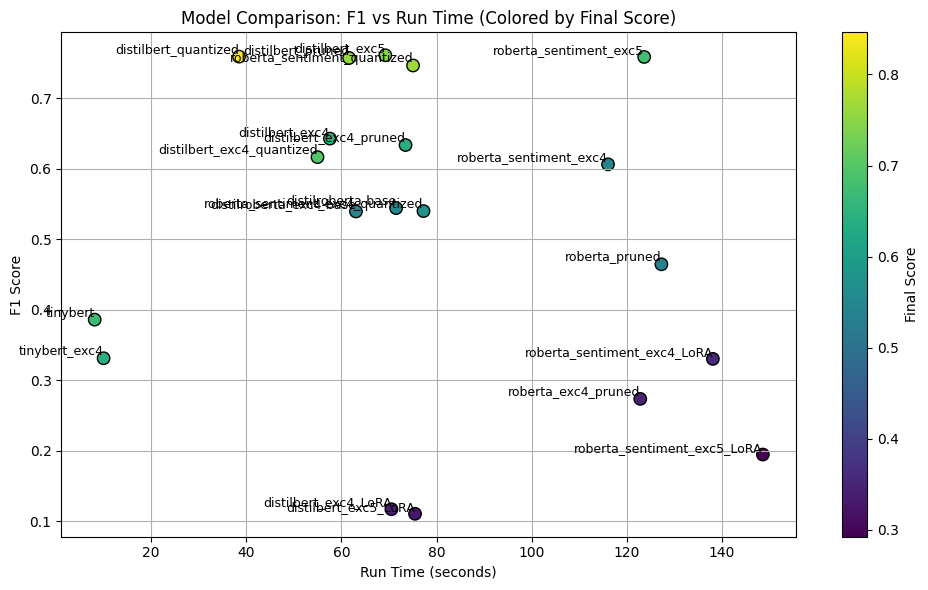

In [26]:
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(10, 6))

# Scatter plot with color based on final_score
sc = plt.scatter(
    evaluation_df['runtime_sec'],
    evaluation_df['f1'],
    c=evaluation_df['final_score'],
    cmap='viridis',
    s=80,
    edgecolors='black'
)

# Annotate each point with the model name (index)
for idx, row in evaluation_df.iterrows():
    plt.text(row['runtime_sec'], row['f1'], idx, fontsize=9, ha='right', va='bottom')

# Add colorbar
cbar = plt.colorbar(sc)
cbar.set_label('Final Score')

# Labels and title
plt.xlabel('Run Time (seconds)')
plt.ylabel('F1 Score')
plt.title('Model Comparison: F1 vs Run Time (Colored by Final Score)')
plt.grid(True)
plt.tight_layout()

# Save the figure
plt.savefig('model_comparison_plot.png', dpi=300)  # Change filename or dpi if needed

# Show the plot
plt.show()


In [27]:
evaluation_df[['f1', 'runtime_sec', 'final_score']]

,f1,runtime_sec,final_score
distilbert_quantized,0.759337,38.471413,0.846188
roberta_sentiment_quantized,0.74678,75.045219,0.764332
distilbert_pruned,0.757465,61.594472,0.759379
distilbert_exc5,0.76129,69.211689,0.746379
distilbert_exc4_quantized,0.616722,54.95781,0.696522
roberta_sentiment_exc5,0.75888,123.63319,0.678073
tinybert,0.386043,8.114999,0.667367
distilbert_exc4,0.642991,57.562709,0.648414
tinybert_exc4,0.331221,9.988089,0.640642
distilbert_exc4_pruned,0.633854,73.46155,0.637672


confusion matrix only for the chosen Roberta model and the chosen Distilbert model.

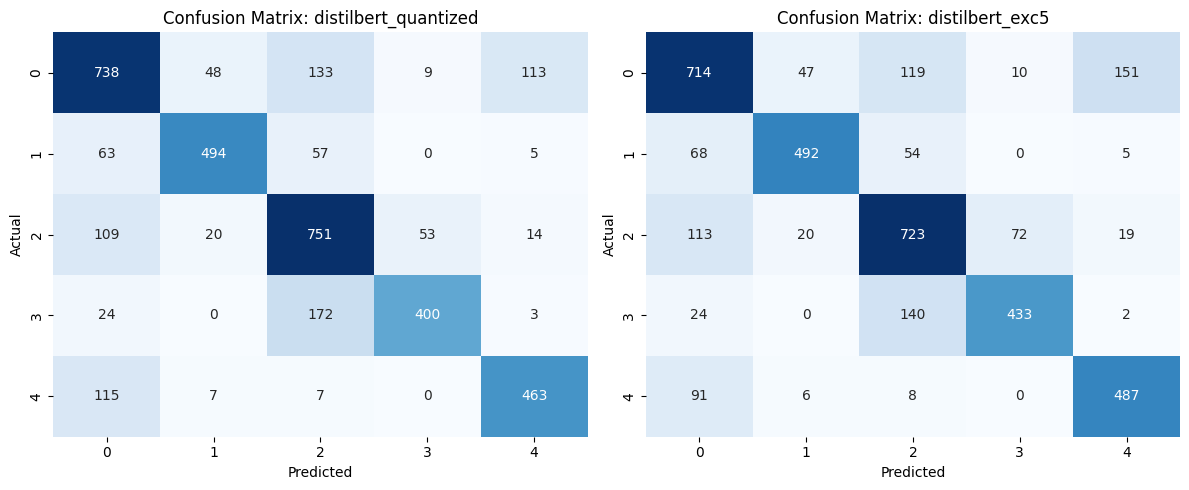

In [29]:
selected_rows = evaluation_df.iloc[[0, 3]]

# Set up the figure for 1x2 subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot each selected confusion matrix
for i, (idx, row) in enumerate(selected_rows.iterrows()):
    ax = axes[i]
    cm = row['conf_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_title(f'Confusion Matrix: {idx}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.savefig('conf_mat.png', dpi=300)

plt.tight_layout()
plt.show()

<center><h1>END</h1></center>
